In [10]:
# looking at efeds data

import astropy.io.fits as fits
import numpy as np
from astropy.table import unique,Table,setdiff,hstack,join
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import warnings
from scipy.stats import sem
warnings.filterwarnings("ignore")

efedslums = Table.read('/suphys/fscu5535/python_scripts/raw_data/efedswithLums.fit',memmap=True)
efedslums.info()
efedsold = Table.read('/suphys/fscu5535/python_scripts/raw_data/eFedsOpticalClusterAndGroupCatalog.csv')
efedsold.info
gamagroups = Table.read('/suphys/fscu5535/python_scripts/raw_data/G3CFoFGroupv10.fits',memmap=True)

<Table length=542>
      name       dtype      unit    
--------------- ------- ------------
       _RAJ2000 float64          deg
       _DEJ2000 float64          deg
          recno   int32             
             ID bytes22             
         ID-SRC   int32             
        RAJ2000 float64          deg
        DEJ2000 float64          deg
        ExtLike float64             
        DetLike float64             
              z float64             
          zType   int16             
        T300kpc float64          keV
      e_T300kpc float64          keV
   e_t300kpc_lc float64          keV
        L300kpc float64       1e+36W
      e_L300kpc float64       1e+36W
   e_l300kpc_lc float64       1e+36W
     Lbol300kpc float64       1e+36W
   e_Lbol300kpc float64       1e+36W
e_lbol300kpc_lc float64       1e+36W
        F300kpc float64 1e-17W.m**-2
      e_F300kpc float64 1e-17W.m**-2
   e_f300kpc_lc float64 1e-17W.m**-2
        T500kpc float64          keV
      e_T500kpc flo

In [9]:
data = Table()
data['M_500'] = M_500

data = hstack([efedslums['RAJ2000'],efedslums['DEJ2000'],efedslums['z'],efedslums['L500kpc']*10e43,data])

data.info()

IndexError: index 0 is out of bounds for axis 0 with size 0

In [29]:
# write to file
data.write('/suphys/fscu5535/python_scripts/mod_data/eFEDS1.0.fits')

In [30]:
# inspect dynamical mass of groups in gama to see if M_500 looks correct
groups = Table.read('/suphys/fscu5535/python_scripts/raw_data/G3CFoFGroupv10.fits',memmap=True)


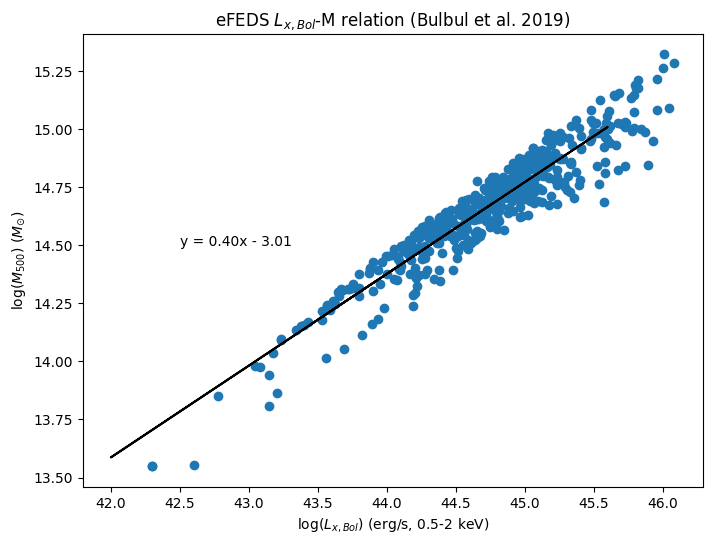

In [11]:
# Use Lx-M relation in Bulbul et al 2019 // Liu et al 2022 with Klein et al 2022
# best fit values

z_piv = 0.45
M_piv = 6.35e14
omega_M = 0.3
omega_L = 0.7
E_zpiv = np.sqrt(omega_M * ((1 + z_piv)**3) + omega_L)

ClusterID = []
M_500 = []
L_500 = []
efedsRA = []
Lbol_500 = []

for i in range(len(efedslums)):
    
    # this avoids bad data
    if efedslums['L500kpc'][i]*10e43 > 100 and efedslums['Lbol500kpc'][i]*10e43 > 100:
        
        L_500.append(np.log10(efedslums['L500kpc'][i]*10e43))
        Lbol_500.append(np.log10(efedslums['Lbol500kpc'][i]*10e43))
    
        E_z = np.sqrt(omega_M * ((1 + efedslums['z'][i])**3) + omega_L)

        mass = M_piv*(1/((4.15e44*(1/(efedslums['L500kpc'][i]*10e43))*((E_z/E_zpiv)**2)*(((1+efedslums['z'][i])/(1+z_piv))**0.252))**(1/1.91)))

        ClusterID.append(efedslums['ID'][i])
        M_500.append(np.log10(mass))
        efedsRA.append(efedslums['RAJ2000'][i])
    

bulbul = Table()
bulbul['efedsID'] = ClusterID
#bulbul['efedsRA'] = efedsRA
bulbul['M_500'] = M_500

M_500 = np.asarray(M_500)
L_500 = np.asarray(L_500)
Lbol_500 = np.asarray(Lbol_500)
ClusterID = np.asarray(ClusterID)

# now get equation of line of best fit and replot with that line
a, b = np.polyfit(Lbol_500, M_500, 1)

plt.figure(figsize=(8,6),dpi=100)
plt.scatter(Lbol_500,M_500)
plt.plot(L_500, a*L_500+b,color='black')
plt.title(r'eFEDS $L_{x,Bol}$-M relation (Bulbul et al. 2019)')
plt.xlabel(r"log($L_{x,Bol}$) (erg/s, 0.5-2 keV)")
plt.ylabel(r"log($M_{500}$) ($M_{\odot}$)")
plt.text(42.5,14.5, 'y = ' + '{:.2f}'.format(a) + 'x' + ' - {:.2f}'.format(-b), size=10)
filename = "/suphys/fscu5535/python_scripts/figures/Lx-MRelationBulbul.png"
plt.savefig(filename, bbox_inches='tight', pad_inches=0.3, dpi = 250)


1.0510919048711338 -1.8629206589400487


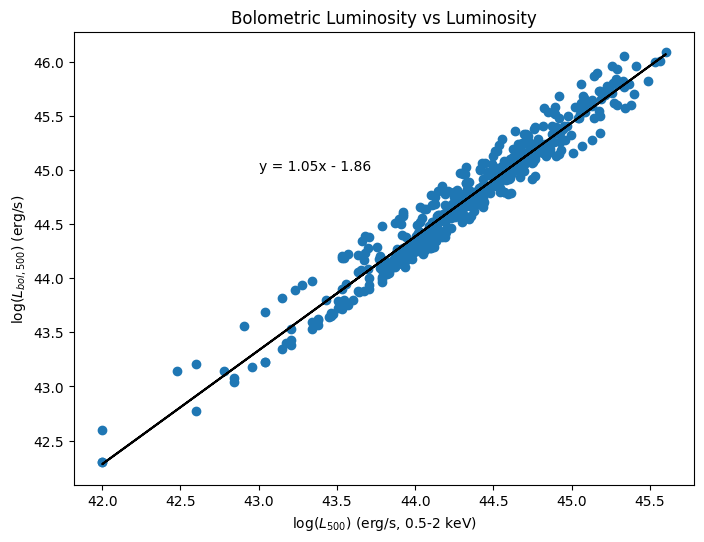

In [12]:
# plot L500 vs Lbol500
a, b = np.polyfit(L_500, Lbol_500, 1)
plt.figure(figsize=(8,6),dpi=100)
plt.scatter(L_500,Lbol_500)
plt.plot(L_500, a*L_500+b,c='black')
plt.title('Bolometric Luminosity vs Luminosity')
plt.xlabel(r"log($L_{500}$) (erg/s, 0.5-2 keV)")
plt.ylabel(r"log($L_{bol,500}$) (erg/s)")
plt.text(43,45, 'y = ' + '{:.2f}'.format(a) + 'x' + ' - {:.2f}'.format(-b), size=10)
filename = "/suphys/fscu5535/python_scripts/figures/BolLumvsLum.png"
plt.savefig(filename, bbox_inches='tight', pad_inches=0.3, dpi = 250)
print(a,b)

In [121]:
# Now we want to plot predicted m_500 with massa from gama, for gama gals only of course
# matching eFEDS and GAMA because script is running in other notebook..
matchingAngle = 500/3600
matchingRedshift = 0.02

gamacentralRA = list()
gamacentralDec = list()
gamacentralZ = list()
gamaGroupID = list()
gamaMassA = list()
gamaNfof = list()
gamaRgap = list()

efedscentralRA = list()
efedscentralDec = list()
efedscentralZ = list()
efedscentralLbol500 = list()
efedscentralL500 = list()
efedsID = list()

for i in range(len(efedslums)):
    
    if efedslums['L500kpc'][i]*10e43 > 100 and efedslums['Lbol500kpc'][i]*10e43 > 100:
       
        for j in range(len(gamagroups)):
            if (np.sqrt((efedslums['RAJ2000'][i] - gamagroups['IterCenRA'][j])**2
                        + (efedslums['DEJ2000'][i] - gamagroups['IterCenDec'][j])**2) < matchingAngle
                and abs(efedslums['z'][i] - gamagroups['Zfof'][j]) < matchingRedshift
               and gamagroups['IterCenRA'][j] not in gamacentralRA):

                gamacentralRA.append(gamagroups['IterCenRA'][j])
                gamacentralDec.append(gamagroups['IterCenDec'][j])
                gamacentralZ.append(gamagroups['Zfof'][j])
                gamaGroupID.append(gamagroups['GroupID'][j])
                gamaMassA.append(gamagroups['MassA'][j])
                gamaNfof.append(gamagroups['Nfof'][j])
                gamaRgap.append(gamagroups['Rgap'][j])

                efedscentralRA.append(efedslums['RAJ2000'][i])
                efedscentralDec.append(efedslums['DEJ2000'][i])
                efedscentralZ.append(efedslums['z'][i])
                efedscentralLbol500.append(efedslums['Lbol500kpc'][i]*10e43)
                efedscentralL500.append(efedslums['L500kpc'][i]*10e43)         
                efedsID.append(efedslums['ID'][i])

                break
            

matchedGals = Table()
matchedGals['gamaRA'] = gamacentralRA
matchedGals['gamaDec'] = gamacentralDec
matchedGals['gamaZ'] = gamacentralZ
matchedGals['GroupID'] = gamaGroupID
matchedGals['MassA'] = gamaMassA
matchedGals['Nfof'] = gamaNfof
matchedGals['Rgap'] = gamaRgap
matchedGals['efedsRA'] = efedscentralRA
matchedGals['efedsDec'] = efedscentralDec
matchedGals['efedsZ'] = efedscentralZ
matchedGals['Lbol500kpc'] = efedscentralLbol500
matchedGals['L500kpc'] = efedscentralL500
matchedGals['efedsID'] = efedsID

print(len(gamaGroupID),"matches found.")

152 matches found.


In [122]:
# now left join m500 data
efedsGamamatches = join(matchedGals,bulbul,keys='efedsID',join_type='left')
efedsGamamatches.info()

<Table length=152>
   name     dtype 
---------- -------
    gamaRA float64
   gamaDec float64
     gamaZ float32
   GroupID   int32
     MassA float32
      Nfof   int16
      Rgap float32
   efedsRA float64
  efedsDec float64
    efedsZ float64
Lbol500kpc float64
   L500kpc float64
   efedsID   str22
     M_500 float64


In [7]:
print(a,b)

0.1695376002625992 12.19393520022664


In [126]:
# write to file
efedsGamamatches.write('/suphys/fscu5535/python_scripts/mod_data/efedsGamamatches500arcs0.02z.fits',overwrite=True)

In [14]:
z_piv = 0.45
M_piv = 6.35e14
omega_M = 0.3
omega_L = 0.7
E_zpiv = np.sqrt(omega_M * ((1 + z_piv)**3) + omega_L)

z_sami = 0.05
    
E_z = np.sqrt(omega_M * ((1 + z_sami)**3) + omega_L)

mass = M_piv*(1/((4.15e44*(1/(1.58e41))*((E_z/E_zpiv)**2)*(((1 + z_sami)/(1+z_piv))**0.252))**(1/1.91)))

print(np.log10(mass))

13.129438484102263
